# Setting the Environment seed

In [1]:
import os, warnings
import matplotlib.pyplot as plt
import urllib
import tarfile
from matplotlib import gridspec
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
import seaborn as sns

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
import keras
import glob
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

import warnings
warnings.filterwarnings('ignore')

In [2]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz']


def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz


# Loading the Image Data

In [3]:
dir_name = '/content/data/images/*'
pets_files = glob.glob(dir_name)
pets_df = pd.DataFrame(pets_files)
pets_df.columns = ['full_path']
pets_df['file_name'] = pets_df['full_path'].str.split('images/').str[1]

def categorize_label(file_name):
    if file_name[0].istitle():
        return "Kucing"
    else:
        return "Anjing"

pets_df['label'] = pets_df['file_name'].apply(categorize_label)
pets_df = shuffle(pets_df, random_state=42).reset_index(drop=True)  # Shuffle data
pets_df.head()

,full_path,file_name,label
0,/content/data/images/pug_67.jpg,pug_67.jpg,Anjing
1,/content/data/images/wheaten_terrier_125.jpg,wheaten_terrier_125.jpg,Anjing
2,/content/data/images/english_cocker_spaniel_15...,english_cocker_spaniel_152.jpg,Anjing
3,/content/data/images/german_shorthaired_57.jpg,german_shorthaired_57.jpg,Anjing
4,/content/data/images/Birman_164.jpg,Birman_164.jpg,Kucing


In [4]:
classNames = pets_df.label.unique()

# Split Data

In [5]:
from sklearn.model_selection import train_test_split

# Assuming pets_df is your original dataframe
train_df, test_df = train_test_split(pets_df, test_size=0.2, random_state=42, stratify=pets_df['label'])

# Declare Necessary Classes

In [6]:
def my_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    f1_Score = f1_score(y_true, y_pred, average='weighted')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1_Score))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1_Score

## CNN + Transfer Learning Resnet50 Models

In [7]:
def get_model():
    resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
    pretrained_base = hub.KerasLayer(resnset50, trainable=False)
    model = keras.Sequential([
        pretrained_base,
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

model = get_model()

In [8]:
# Define ImageDataGenerator outside of the loop to avoid re-initialization
train_datagen = image.ImageDataGenerator(rescale=1/255., validation_split=0.2, rotation_range=20, horizontal_flip=True, vertical_flip=True)

# Set up KFold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
results = []

for train_index, val_index in kf.split(pets_df):

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='/content/data/images',
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=100,
        subset='training',
        seed=42
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='/content/data/images',
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=50,
        subset='validation',
        seed=42
    )

    print(f'TRAINING FOLD {fold_no}')
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=5,
    )

  # Evaluate the model on the validation set
    print("**Evaluation on Validation data**")
    ev_val_loss, ev_val_accuracy = model.evaluate(validation_generator)
    print(f'Validation Loss: {ev_val_loss} - Validation Accuracy: {ev_val_accuracy}')

  # evaluate validation performance
    print("**Performance on Validation data**")
    predictions = model.predict(validation_generator, verbose=1)
    y_predictions = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)

    results.append({
        'fold': fold_no,
        'history': history.history,
        'ev_val_loss': ev_val_loss,
        'ev_val_accuracy': ev_val_accuracy,
        'val_accuracy': val_acc,
        'precision': val_prec,
        'f1_score': val_fScore,
    })

    fold_no += 1


Found 4729 validated image filenames belonging to 2 classes.
Found 1182 validated image filenames belonging to 2 classes.
TRAINING FOLD 1
Epoch 1/5
48/48 [==============================] - 115s 2s/step - loss: 0.4101 - accuracy: 0.8613 - val_loss: 0.1495 - val_accuracy: 0.9450
Epoch 2/5
48/48 [==============================] - 95s 2s/step - loss: 0.1731 - accuracy: 0.9380 - val_loss: 0.1232 - val_accuracy: 0.9594
Epoch 3/5
48/48 [==============================] - 93s 2s/step - loss: 0.1414 - accuracy: 0.9497 - val_loss: 0.1170 - val_accuracy: 0.9560
Epoch 4/5
48/48 [==============================] - 104s 2s/step - loss: 0.1237 - accuracy: 0.9503 - val_loss: 0.1239 - val_accuracy: 0.9459
Epoch 5/5
48/48 [==============================] - 95s 2s/step - loss: 0.1215 - accuracy: 0.9543 - val_loss: 0.1076 - val_accuracy: 0.9636
**Evaluation on Validation data**
24/24 [==============================] - 17s 724ms/step - loss: 0.1089 - accuracy: 0.9535
Validation Loss: 0.10890024900436401 - Va

In [14]:
# Find the best fold based on validation accuracy, precision, recall, or f1-score
best_result = max(results, key=lambda x: x['val_accuracy'])  # Change 'val_accuracy' to any metric you prefer

print("\nBest fold results:")
print(f"Fold: {best_result['fold']}")
print(f"Performance Validation Accuracy: {best_result['val_accuracy']}")
print(f"Performance Precision: {best_result['precision']}")
print(f"Performance F1 Score: {best_result['f1_score']}")


Best fold results:
Fold: 3
Performance Validation Accuracy: 0.5939086294416244
Performance Precision: 0.5876043966573173
Performance F1 Score: 0.5906059115285479


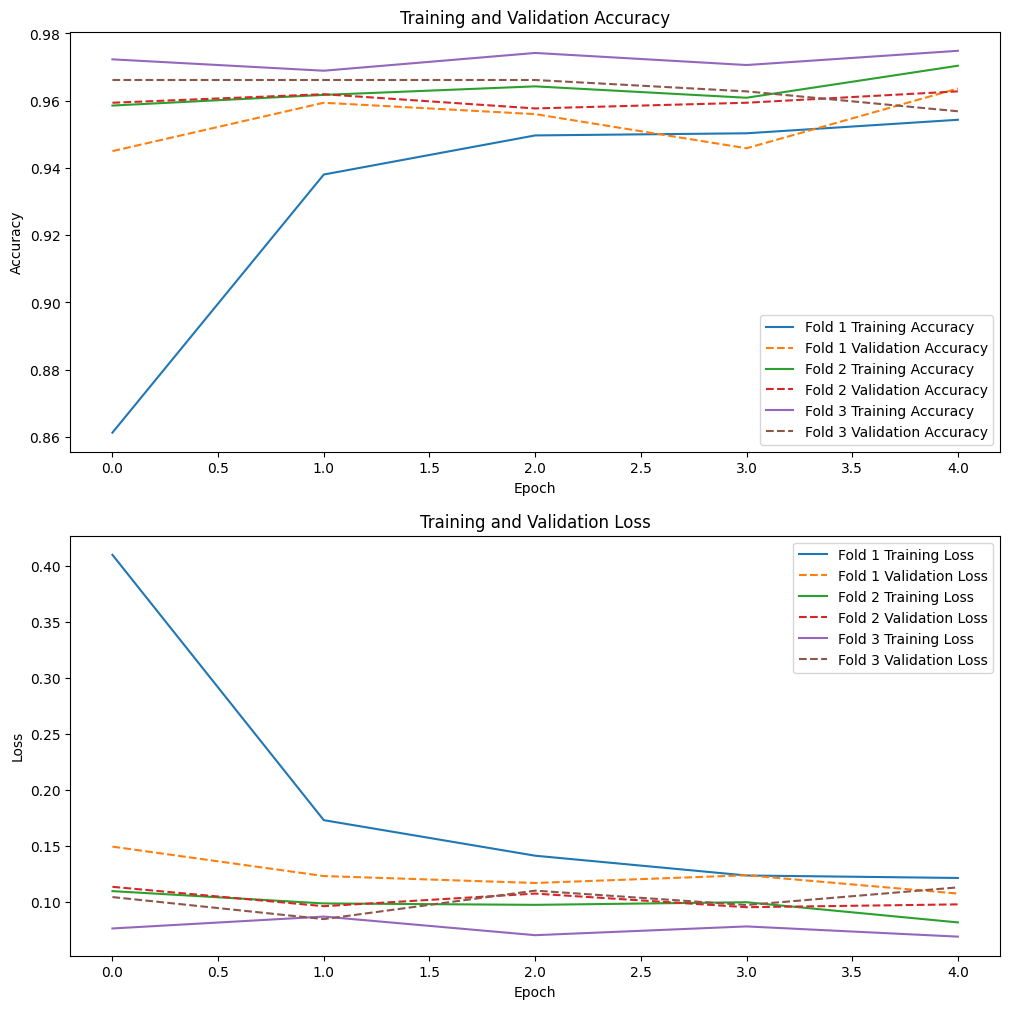

In [15]:
# Plotting cross-validation results
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

for result in results:
    ax[0].plot(result['history']['accuracy'], label=f'Fold {result["fold"]} Training Accuracy')
    ax[0].plot(result['history']['val_accuracy'], linestyle='--', label=f'Fold {result["fold"]} Validation Accuracy')

ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

for result in results:
    ax[1].plot(result['history']['loss'], label=f'Fold {result["fold"]} Training Loss')
    ax[1].plot(result['history']['val_loss'], linestyle='--', label=f'Fold {result["fold"]} Validation Loss')

ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()


In [16]:
print("==============TEST RESULTS============")

test_datagen = image.ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/data/images',
    x_col='file_name',
    y_col='label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=50,
    shuffle=False
)

predictions = model.predict(test_generator, verbose=1)
y_predictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

test_acc, test_prec, test_fScore = my_metrics(true_classes, y_predictions)

==============TEST RESULTS============
Found 1479 validated image filenames belonging to 2 classes.
30/30 [==============================] - 14s 480ms/step
Accuracy  : 0.9871534820824882
Precision : 0.9873934858587249
f1Score : 0.9870846300009513
[[998   0]
 [ 19 462]]


Confusion Matrix:
[[998   0]
 [ 19 462]]


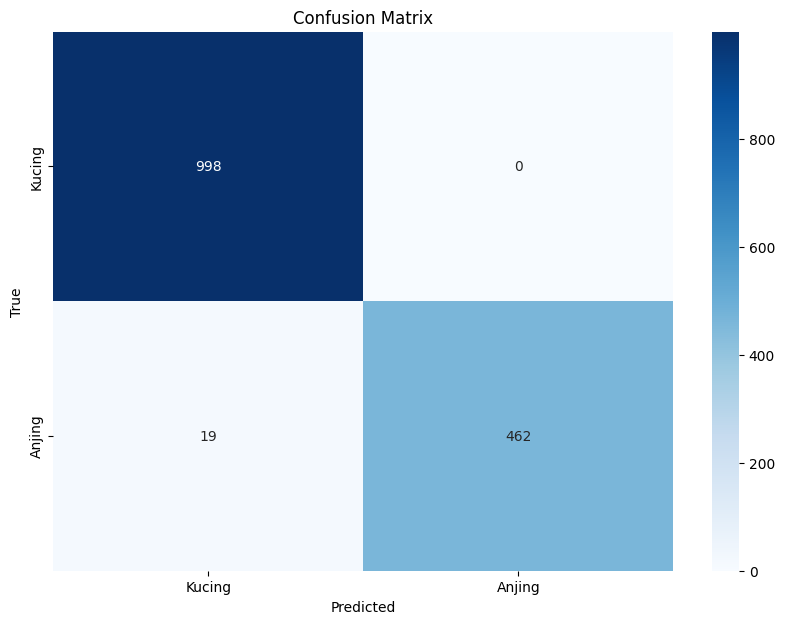

In [17]:
# Generate confusion matrix
cm = confusion_matrix(true_classes, y_predictions)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Kucing', 'Anjing'], yticklabels=['Kucing', 'Anjing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

2/2 [==============================] - 0s 109ms/step
Predicted Class: Kucing
Correct Class : Kucing


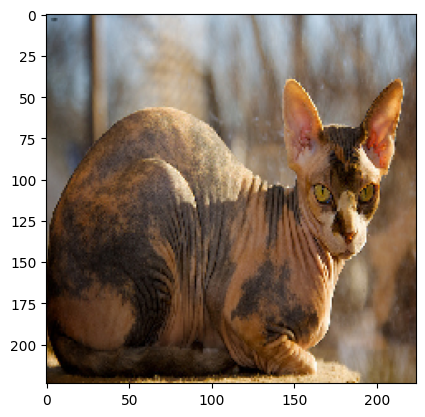

In [24]:
X_test, y_test = next(test_generator)
y_proba = model.predict(X_test)
for i in range(len(y_proba)):
    classFinal = y_proba[0].argmax()
    print(f'Predicted Class: {classNames[classFinal]}')
    print(f'Correct Class : {classNames[y_test[i].argmax()]}')
    plt.imshow(X_test[i])
    break